# KAGGLE. Сериал "Игровая площадка", 3 сезон, 2 серия
# Прогноз инсульта

Dataset Description:  
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

# Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from catboost.utils import get_roc_curve, select_threshold
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from imblearn.over_sampling import SMOTENC, SMOTE


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

state = 10012023

In [2]:
# функции

# функция для изучения данных
def def_info(df):
    print('Размер таблицы:', df.shape)
    print('____________________________________')
    print()
    print('Общая информация')
    print(df.info())
    print('____________________________________')
    print()
    print('Вывод 5и первых строк')
    display(df.head())
    print('____________________________________')
    print()
    print('Доля пропусков в таблице:')
    print(df.isna().mean())
    print('____________________________________')
    print()
    print('Доля явных дублей в данных:', df.duplicated().mean())

# функция для изучения выбросов и аномалий в данных
def boxplot_make(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist)
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');
    
# функция для изучения распределения данных по целевому признаку
def result_table(data, column, target):
    table = (data.groupby(column)[target].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')
    return table

In [3]:
# чтение данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
def_info(train)

Размер таблицы: (15304, 12)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB
None
____________________________________

Вывод 5и первых строк


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


____________________________________

Доля пропусков в таблице:
id                   0.0
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [5]:
def_info(test)

Размер таблицы: (10204, 11)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10204 non-null  int64  
 1   gender             10204 non-null  object 
 2   age                10204 non-null  float64
 3   hypertension       10204 non-null  int64  
 4   heart_disease      10204 non-null  int64  
 5   ever_married       10204 non-null  object 
 6   work_type          10204 non-null  object 
 7   Residence_type     10204 non-null  object 
 8   avg_glucose_level  10204 non-null  float64
 9   bmi                10204 non-null  float64
 10  smoking_status     10204 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 877.0+ KB
None
____________________________________

Вывод 5и первых строк


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


____________________________________

Доля пропусков в таблице:
id                   0.0
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [6]:
# названия столбцов приведем к нижнему регистру
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

# Короткий исследовательский анализ

In [7]:
train.describe(include='object')

,gender,ever_married,work_type,residence_type,smoking_status
count,15304,15304,15304,15304,15304
unique,3,2,5,2,4
top,Female,Yes,Private,Rural,never smoked
freq,9446,10385,9752,7664,6281


In [8]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [9]:
test.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000
mean,20405.500000,41.920713,0.051450,0.021756,89.197766,28.242351
std,2945.785407,21.097956,0.220925,0.145894,25.914364,6.733863
min,15304.000000,0.080000,0.000000,0.000000,55.120000,11.500000
25%,17854.750000,26.000000,0.000000,0.000000,75.060000,23.700000
50%,20405.500000,43.500000,0.000000,0.000000,85.070000,27.700000
75%,22956.250000,57.000000,0.000000,0.000000,96.750000,32.000000
max,25507.000000,82.000000,1.000000,1.000000,267.600000,97.600000


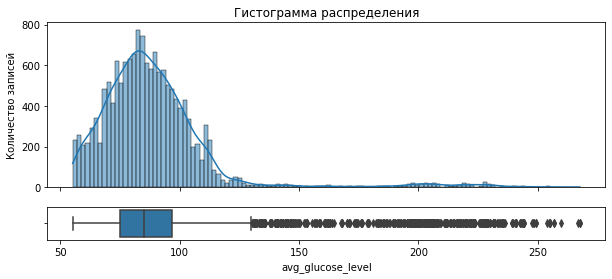

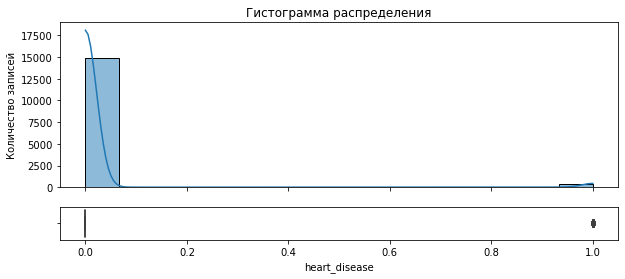

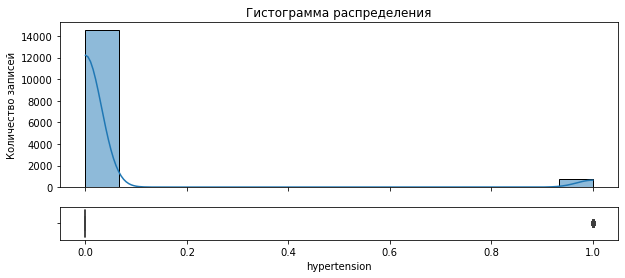

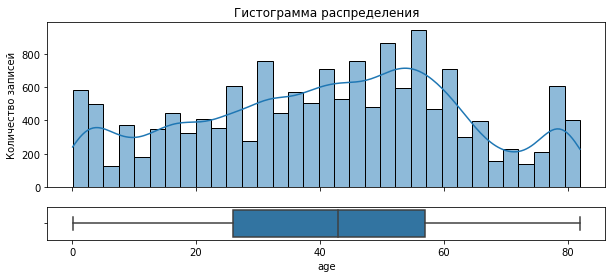

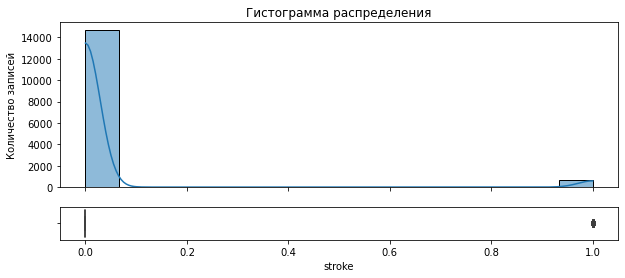

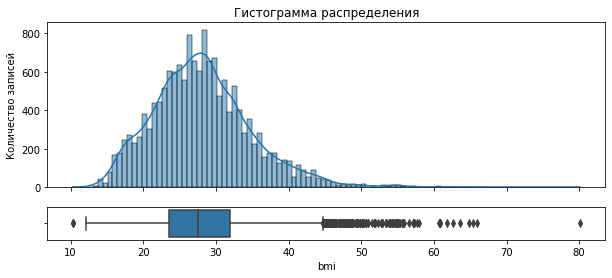

In [10]:
# проверим данные на аномалии и посмотрим распределение
for col in set(train.select_dtypes(include='number').columns)-set(['id']):
    boxplot_make(train, col)

> **Имеем сильный дисбаланс классов. При этом доля объектов с положительным классом очень маленькая ~ 4%**

In [11]:
# построим портрет "инсультника"
for col in set(train.columns)-set(['id', 'stroke', 'avg_glucose_level', 'age', 'bmi']):
    display(result_table(train, col, 'stroke'))

,sum,count,share
smoking_status,,,
formerly smoked,159,2337,0.068036
smokes,108,2143,0.050397
never smoked,257,6281,0.040917
Unknown,108,4543,0.023773


,sum,count,share
work_type,,,
Self-employed,158,1939,0.081485
Govt_job,69,1533,0.045010
Private,404,9752,0.041427
children,1,2038,0.000491
Never_worked,0,42,0.000000


,sum,count,share
heart_disease,,,
1,66,357,0.184874
0,566,14947,0.037867


,sum,count,share
hypertension,,,
1,128,761,0.168200
0,504,14543,0.034656


,sum,count,share
gender,,,
Male,264,5857,0.045074
Female,368,9446,0.038958
Other,0,1,0.000000


,sum,count,share
ever_married,,,
Yes,591,10385,0.056909
No,41,4919,0.008335


,sum,count,share
residence_type,,,
Rural,317,7664,0.041362
Urban,315,7640,0.041230


In [12]:
display(result_table(train, pd.qcut(train['age'], 5), 'stroke'))

,sum,count,share
age,,,
"(60.0, 82.0]",457,2911,0.156991
"(49.0, 60.0]",140,3101,0.045147
"(37.0, 49.0]",24,2988,0.008032
"(20.0, 37.0]",10,3227,0.003099
"(0.079, 20.0]",1,3077,0.000325


In [13]:
display(result_table(train, pd.qcut(train['bmi'], 3), 'stroke'))

,sum,count,share
bmi,,,
"(30.2, 80.1]",281,5074,0.055380
"(25.0, 30.2]",252,5067,0.049734
"(10.299000000000001, 25.0]",99,5163,0.019175


In [14]:
display(result_table(train, pd.qcut(train['avg_glucose_level'], 3), 'stroke'))

,sum,count,share
avg_glucose_level,,,
"(92.67, 267.6]",282,5098,0.055316
"(55.219, 78.79]",203,5102,0.039788
"(78.79, 92.67]",147,5104,0.028801


# Проверка признаков

1.Blood glucose- preprandial test  
a. Normal level -- 50-99 mg/dl  
b. Prediabetic -- 100-125 mg/dl  
c. Diabetic -- 126 mg/dl ++  
  
2.Blood glucose- postprandial test  
a. Normal level -- < 140 mg/dl  
b. Prediabetic -- 140-199 mg/dl  
c. Diabetic -- 200 mg/dl ++  
  
3.BMI  
a. Underweight -- < 18.5  
b. Normal -- 18.5 - 24.99  
c. Overweight -- 25- 29.99  
d. Obsese-category1 -- 30- 34.99  
e. Obsese-category2 -- 35 - 39.99  
f. Obese category3 -- 40++  
  
4.Age  
a. Age < 45 years -- low risk of heart disease (ACSM)  
  
b. Age >= 45 years -- higher risk of heart disease (ACSM)  
  
c. Generally, 65 years of age is considered as a cutoff for general medical practice for heart disease  

In [15]:
train.corr().style.background_gradient(low=0.1, cmap='YlOrRd')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,-0.003302,-0.012186,-0.005429,0.001450,-0.013436,-0.017290
age,-0.003302,1.000000,0.232629,0.193394,0.108897,0.390721,0.261320
hypertension,-0.012186,0.232629,1.000000,0.074178,0.122834,0.106665,0.145895
heart_disease,-0.005429,0.193394,0.074178,1.000000,0.137147,0.054583,0.111518
avg_glucose_level,0.001450,0.108897,0.122834,0.137147,1.000000,0.108142,0.149273
bmi,-0.013436,0.390721,0.106665,0.054583,0.108142,1.000000,0.065393
stroke,-0.017290,0.261320,0.145895,0.111518,0.149273,0.065393,1.000000


In [16]:
# проверим признаки на мультиколлинеарность
# создадим копию
X = train.copy()
y = X.pop('stroke')
# проведем преобразование
for col in list(X.select_dtypes(include=['object', 'category']).columns):
    X[col], _ = X[col].factorize()
scores = pd.Series(mutual_info_classif(X, y), index=X.columns).sort_values(ascending=False)
scores.to_frame('scores').style.background_gradient(low=0.1, cmap='YlOrRd')

,scores
age,0.043830
avg_glucose_level,0.016033
work_type,0.007504
ever_married,0.007283
bmi,0.006492
hypertension,0.005145
smoking_status,0.003190
heart_disease,0.002373
gender,0.002042
residence_type,0.000435


# Подготовка датасетов

In [55]:
# функция для преобразования признаков
def make_features(df, drop_list=['id', 'residence_type']):
    df_new = df.copy()    
    df_new = df_new.loc[df_new['gender'] != 'Other']
    for col in list(df_new.select_dtypes(include='object').columns):
        df_new[col] = df_new[col].astype('category')
#     drop_list = set(list(df_new.columns)) - set(['bmi', 'avg_glucose_level', 'age', 'stroke'])

    df_new = df_new.drop(drop_list, axis=1)
    return df_new

# функция для pipline
def make_df(X):
    cols = (numeric_features + cat_features + binary_features)
    X = pd.DataFrame(X, columns=cols)
    return X 

# функция для увеличения объектов положительного класса
def upsample_make(X, y, test_size=.5):
    _, X_small, _, y_small = train_test_split(X, y, test_size=test_size, random_state=state)
    oversample = SMOTE(random_state=state, k_neighbors=3)
    X_small, y_small = oversample.fit_resample(X_small, y_small)
    X = pd.concat([X, X_small])
    y = pd.concat([y, y_small])
    return X, y

In [18]:
train_df = make_features(train)
test_df = make_features(test)
X_df = train_df.drop('stroke', axis=1)
y_df = train_df[['stroke']]

In [19]:
numeric_features = list(test_df.select_dtypes(include='float').columns)
cat_features = list(test_df.select_dtypes(include='category').columns)
binary_features = list(test_df.select_dtypes(include='int').columns)

In [20]:
numeric_features, cat_features, binary_features

(['age', 'avg_glucose_level', 'bmi'],
 ['gender', 'ever_married', 'work_type', 'smoking_status'],
 ['hypertension', 'heart_disease'])

In [21]:
processor = ColumnTransformer(transformers = [('std_scaler', StandardScaler(), numeric_features),
                                                 ('cat', OrdinalEncoder(), cat_features),
                                                 ('binary', OneHotEncoder(drop='first'), binary_features)])

pl = Pipeline(steps = [('processor', processor),
                       ('make_df', FunctionTransformer(make_df))])

In [22]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=state)

In [23]:
models_results = {
            'best_score': [],
            'rocauc': [],
            'precision': [],
            'recall': [],
            'model': []
        }

# Подбор моделей

# Модели без Pipline

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=.25, random_state=state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11477, 9), (3826, 9), (11477, 1), (3826, 1))

# Catboost

In [25]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
                         , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6872061	test: 0.6872122	test1: 0.6870347	best: 0.6870347 (0)	total: 172ms	remaining: 34.2s
199:	learn: 0.4291350	test: 0.4335602	test1: 0.4229865	best: 0.4229865 (199)	total: 2.54s	remaining: 0us

bestTest = 0.422986504
bestIteration = 199

0:	learn: 0.6873479	test: 0.6872735	test1: 0.6870768	best: 0.6870768 (0)	total: 10.6ms	remaining: 2.1s
199:	learn: 0.4354999	test: 0.4342872	test1: 0.4221578	best: 0.4221578 (199)	total: 2.27s	remaining: 0us

bestTest = 0.4221577954
bestIteration = 199

0:	learn: 0.6873818	test: 0.6873431	test1: 0.6871666	best: 0.6871666 (0)	total: 18.6ms	remaining: 3.7s
199:	learn: 0.4373876	test: 0.4331535	test1: 0.4243442	best: 0.4243442 (199)	total: 2.42s	remaining: 0us

bestTest = 0.4243441515
bestIteration = 199

0:	learn: 0.6862170	test: 0.6862142	test1: 0.6860819	best: 0.6860819 (0)	total: 10.7ms	remaining: 2.13s
199:	learn: 0.4304027	test: 0.4324932	test1: 0.4214357	best: 0.4214357 (199)	total: 2.42s	remaining: 0us

bestTest = 0.42143571
bestIte

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001657A227FA0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [26]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8843478361148444,
 {'learning_rate': 0.1, 'l2_leaf_reg': 6, 'iterations': 500, 'depth': 4})

In [27]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6482025	total: 26.3ms	remaining: 13.1s
1:	learn: 0.6024881	total: 42.1ms	remaining: 10.5s
2:	learn: 0.5634404	total: 57ms	remaining: 9.44s
3:	learn: 0.5334292	total: 74.2ms	remaining: 9.2s
4:	learn: 0.5139569	total: 90.5ms	remaining: 8.96s
5:	learn: 0.4973326	total: 123ms	remaining: 10.1s
6:	learn: 0.4834222	total: 155ms	remaining: 10.9s
7:	learn: 0.4725042	total: 184ms	remaining: 11.3s
8:	learn: 0.4639225	total: 200ms	remaining: 10.9s
9:	learn: 0.4589626	total: 210ms	remaining: 10.3s
10:	learn: 0.4553958	total: 234ms	remaining: 10.4s
11:	learn: 0.4510643	total: 249ms	remaining: 10.1s
12:	learn: 0.4469396	total: 263ms	remaining: 9.84s
13:	learn: 0.4435331	total: 288ms	remaining: 10s
14:	learn: 0.4418503	total: 300ms	remaining: 9.71s
15:	learn: 0.4390709	total: 310ms	remaining: 9.37s
16:	learn: 0.4374771	total: 336ms	remaining: 9.54s
17:	learn: 0.4354223	total: 346ms	remaining: 9.26s
18:	learn: 0.4333381	total: 386ms	remaining: 9.78s
19:	learn: 0.4295143	total: 403ms	remaini

In [28]:
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('Catboost_without_pipline')

In [29]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,30.885815
1,bmi,26.164509
2,avg_glucose_level,24.704429
3,smoking_status,5.697432
4,work_type,5.223597
5,ever_married,3.638825
6,gender,3.047822
7,hypertension,0.421412
8,heart_disease,0.216160


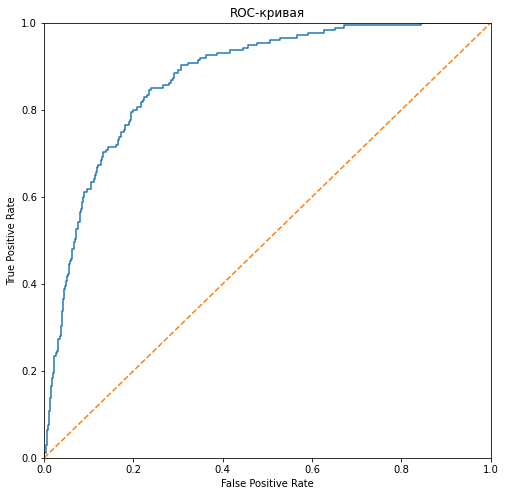

ROC-AUC: 0.8728473608013461


In [30]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [31]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [32]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8815612119611226,
 {'num_leaves': 82,
  'n_estimators': 420,
  'max_depth': 3,
  'learning_rate': 0.005,
  'boosting_type': 'gbdt'})

In [33]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [34]:
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('LGBM_without_pipline')

In [35]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,1230
1,avg_glucose_level,845
2,bmi,516
3,heart_disease,110
4,gender,85
5,ever_married,58
6,work_type,49
7,smoking_status,47
8,hypertension,0


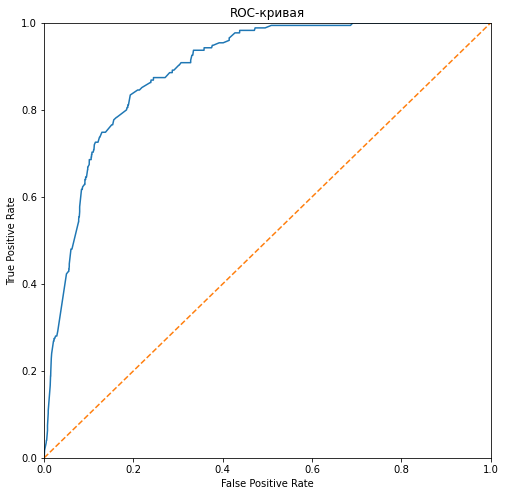

ROC-AUC: 0.8931838635207574


In [36]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Модели с Pipline

In [111]:
X_df_pl = pl.fit_transform(X_df)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11477, 9), (3826, 9), (11477, 1), (3826, 1))

# Catboost

In [112]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6580817	test: 0.6582478	test1: 0.6577182	best: 0.6577182 (0)	total: 1.8ms	remaining: 88.4ms
49:	learn: 0.2998600	test: 0.3386667	test1: 0.4253779	best: 0.4177415 (37)	total: 1.33s	remaining: 0us

bestTest = 0.4177415415
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 0.6598856	test: 0.6602564	test1: 0.6584131	best: 0.6584131 (0)	total: 1.57ms	remaining: 76.8ms
49:	learn: 0.3047036	test: 0.3367754	test1: 0.4320051	best: 0.4286086 (38)	total: 1.5s	remaining: 0us

bestTest = 0.4286086412
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 0.6592152	test: 0.6587742	test1: 0.6580632	best: 0.6580632 (0)	total: 1.62ms	remaining: 79.6ms
49:	learn: 0.2990695	test: 0.3343634	test1: 0.4364371	best: 0.4306703 (39)	total: 1.38s	remaining: 0us

bestTest = 0.4306702948
bestIteration = 39

Shrink model to first 40 iterations.
0:	learn: 0.6603322	test: 0.6603826	test1: 0.6587087	best: 0.6587087 (0)	total: 1.45ms	remaining: 71.2ms
49:	learn: 0.2992347	test: 

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001657A1AE3D0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [113]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8820122836536595,
 {'learning_rate': 0.01, 'l2_leaf_reg': 2, 'iterations': 150, 'depth': 8})

In [40]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6869598	total: 4.91ms	remaining: 2.2s
1:	learn: 0.6811347	total: 8.57ms	remaining: 1.92s
2:	learn: 0.6753489	total: 12ms	remaining: 1.78s
3:	learn: 0.6695069	total: 15.2ms	remaining: 1.7s
4:	learn: 0.6641720	total: 18.7ms	remaining: 1.67s
5:	learn: 0.6579627	total: 22ms	remaining: 1.63s
6:	learn: 0.6535630	total: 25.2ms	remaining: 1.6s
7:	learn: 0.6485802	total: 28.1ms	remaining: 1.55s
8:	learn: 0.6434325	total: 31.4ms	remaining: 1.54s
9:	learn: 0.6385922	total: 34.5ms	remaining: 1.52s
10:	learn: 0.6330642	total: 38ms	remaining: 1.51s
11:	learn: 0.6284539	total: 41.3ms	remaining: 1.51s
12:	learn: 0.6244687	total: 44.3ms	remaining: 1.49s
13:	learn: 0.6206220	total: 47.3ms	remaining: 1.47s
14:	learn: 0.6164965	total: 50.1ms	remaining: 1.45s
15:	learn: 0.6124151	total: 53ms	remaining: 1.44s
16:	learn: 0.6090699	total: 56.1ms	remaining: 1.43s
17:	learn: 0.6048771	total: 59ms	remaining: 1.42s
18:	learn: 0.6008950	total: 61.7ms	remaining: 1.4s
19:	learn: 0.5970765	total: 64.6ms	r

In [41]:
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('Catboost_with_pipline')

In [42]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,62.254019
1,avg_glucose_level,10.746358
2,bmi,8.521362
3,ever_married,5.468300
4,smoking_status,5.308446
5,work_type,5.120162
6,gender,1.135697
7,heart_disease,0.873933
8,hypertension,0.571724


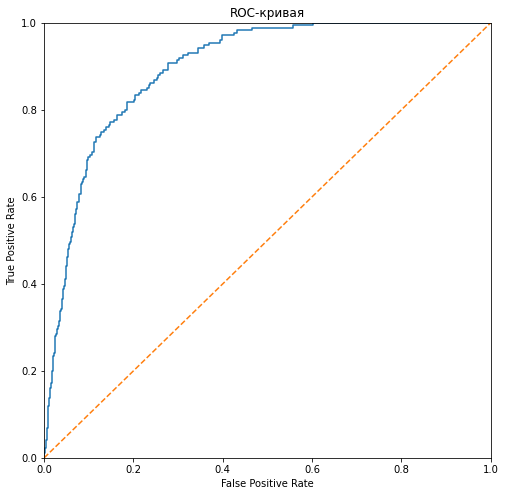

ROC-AUC: 0.8958563211644559


In [43]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [44]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [45]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8853651027120764,
 {'num_leaves': 9,
  'n_estimators': 420,
  'max_depth': 16,
  'learning_rate': 0.01,
  'boosting_type': 'goss'})

In [46]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [47]:
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('LGBM_with_pipline')

In [48]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,1075
1,avg_glucose_level,1037
2,bmi,786
3,work_type,142
4,smoking_status,137
5,gender,62
6,heart_disease,59
7,ever_married,50
8,hypertension,12


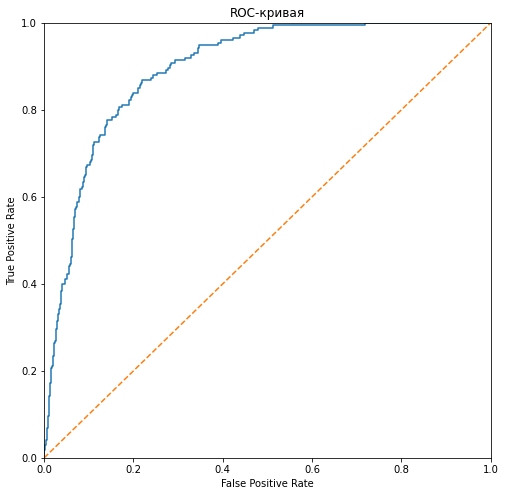

ROC-AUC: 0.895499471768987


In [49]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Модели c Pipline и с Upsample

In [56]:
X_df_pl = pl.fit_transform(X_df)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=state)
X_train, y_train = upsample_make(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((22489, 9), (3826, 9), (22489, 1), (3826, 1))

# Catboost

In [57]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6884487	test: 0.6884815	test1: 0.6886956	best: 0.6886956 (0)	total: 68.7ms	remaining: 3.37s
49:	learn: 0.5252253	test: 0.5265389	test1: 0.5387027	best: 0.5387027 (49)	total: 4.02s	remaining: 0us

bestTest = 0.5387027105
bestIteration = 49

0:	learn: 0.6886455	test: 0.6886864	test1: 0.6890274	best: 0.6890274 (0)	total: 70.1ms	remaining: 3.43s
49:	learn: 0.5252666	test: 0.5264376	test1: 0.5382487	best: 0.5382487 (49)	total: 4.03s	remaining: 0us

bestTest = 0.5382486897
bestIteration = 49

0:	learn: 0.6885070	test: 0.6884801	test1: 0.6884379	best: 0.6884379 (0)	total: 69.6ms	remaining: 3.41s
49:	learn: 0.5276626	test: 0.5269063	test1: 0.5381002	best: 0.5381002 (49)	total: 4s	remaining: 0us

bestTest = 0.5381002265
bestIteration = 49

0:	learn: 0.6883625	test: 0.6883944	test1: 0.6883915	best: 0.6883915 (0)	total: 76.4ms	remaining: 3.75s
49:	learn: 0.5257244	test: 0.5269379	test1: 0.5389893	best: 0.5389893 (49)	total: 3.92s	remaining: 0us

bestTest = 0.5389892525
bestIteration =

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001657B6448B0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [58]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.9864851601454203,
 {'learning_rate': 0.1, 'l2_leaf_reg': 6, 'iterations': 350, 'depth': 12})

In [59]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.5954421	total: 95.4ms	remaining: 33.3s
1:	learn: 0.5209618	total: 185ms	remaining: 32.1s
2:	learn: 0.4673199	total: 274ms	remaining: 31.7s
3:	learn: 0.4306204	total: 363ms	remaining: 31.4s
4:	learn: 0.3947768	total: 457ms	remaining: 31.5s
5:	learn: 0.3714375	total: 560ms	remaining: 32.1s
6:	learn: 0.3476593	total: 665ms	remaining: 32.6s
7:	learn: 0.3333698	total: 822ms	remaining: 35.1s
8:	learn: 0.3204485	total: 916ms	remaining: 34.7s
9:	learn: 0.3091471	total: 1.01s	remaining: 34.4s
10:	learn: 0.2984424	total: 1.11s	remaining: 34.1s
11:	learn: 0.2877651	total: 1.2s	remaining: 33.8s
12:	learn: 0.2778671	total: 1.3s	remaining: 33.6s
13:	learn: 0.2706904	total: 1.4s	remaining: 33.5s
14:	learn: 0.2655188	total: 1.5s	remaining: 33.5s
15:	learn: 0.2589207	total: 1.61s	remaining: 33.6s
16:	learn: 0.2503077	total: 1.74s	remaining: 34s
17:	learn: 0.2444565	total: 1.87s	remaining: 34.6s
18:	learn: 0.2404747	total: 1.96s	remaining: 34.2s
19:	learn: 0.2362999	total: 2.05s	remaining: 3

In [60]:
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('Catboost_pipline+upsample')

In [61]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,26.200046
1,avg_glucose_level,16.202748
2,bmi,15.238991
3,smoking_status,14.088152
4,gender,11.843619
5,work_type,8.508198
6,hypertension,2.993488
7,ever_married,2.932002
8,heart_disease,1.992757


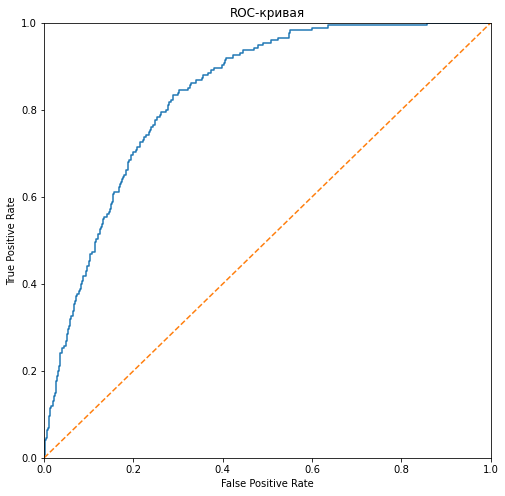

ROC-AUC: 0.8375286614234849


In [62]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [63]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [64]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.9934605921298143,
 {'num_leaves': 175,
  'n_estimators': 900,
  'max_depth': 11,
  'learning_rate': 0.1,
  'boosting_type': 'dart'})

In [65]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [66]:
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('LGBM_pipline+upsample')

In [67]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,avg_glucose_level,40780
1,bmi,40395
2,age,33823
3,smoking_status,12115
4,gender,7315
5,work_type,5827
6,heart_disease,2463
7,hypertension,2383
8,ever_married,2307


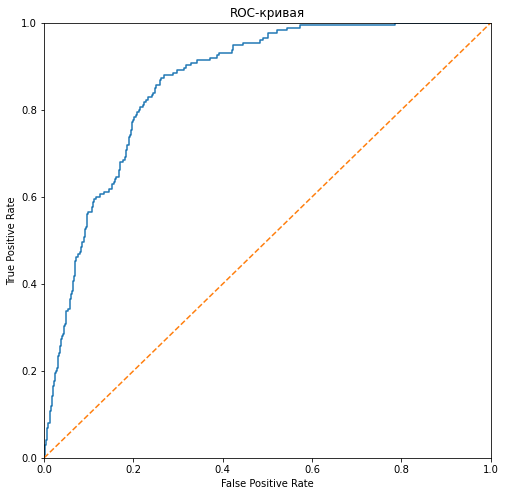

ROC-AUC: 0.8635864929373556


In [68]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Модели Pipline+Upsample+get_dummies

In [70]:
X_df_pl = pl.fit_transform(X_df)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=state)
col_dummies = ['gender', 'ever_married', 'work_type', 'smoking_status', 'hypertension', 'heart_disease']
X_train = pd.get_dummies(X_train, columns=col_dummies)
X_val = pd.get_dummies(X_val, columns=col_dummies)
X_train, y_train = upsample_make(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((22489, 20), (3826, 20), (22489, 1), (3826, 1))

# Catboost

In [71]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6011235	test: 0.6021421	test1: 0.5913863	best: 0.5913863 (0)	total: 67.9ms	remaining: 3.33s
49:	learn: 0.1510585	test: 0.1580959	test1: 0.3089121	best: 0.3086539 (46)	total: 3.66s	remaining: 0us

bestTest = 0.30865391
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 0.5978440	test: 0.5982864	test1: 0.5906103	best: 0.5906103 (0)	total: 70.4ms	remaining: 3.45s
49:	learn: 0.1531514	test: 0.1599420	test1: 0.3086473	best: 0.3086473 (49)	total: 3.58s	remaining: 0us

bestTest = 0.3086472888
bestIteration = 49

0:	learn: 0.5985180	test: 0.5980770	test1: 0.5890858	best: 0.5890858 (0)	total: 75.4ms	remaining: 3.7s
49:	learn: 0.1520064	test: 0.1579068	test1: 0.3084026	best: 0.3072895 (42)	total: 3.76s	remaining: 0us

bestTest = 0.3072894565
bestIteration = 42

Shrink model to first 43 iterations.
0:	learn: 0.5964142	test: 0.5969952	test1: 0.5927297	best: 0.5927297 (0)	total: 72.8ms	remaining: 3.57s
49:	learn: 0.1457729	test: 0.1564618	test1: 0.3089763	best: 0.3084656

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001650BC66730>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [72]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.9890725575028713,
 {'learning_rate': 0.1, 'l2_leaf_reg': 6, 'iterations': 400, 'depth': 8})

In [73]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6129471	total: 39.1ms	remaining: 15.6s
1:	learn: 0.5591382	total: 53.2ms	remaining: 10.6s
2:	learn: 0.5240155	total: 56.9ms	remaining: 7.53s
3:	learn: 0.4854927	total: 64.9ms	remaining: 6.42s
4:	learn: 0.4533352	total: 73.3ms	remaining: 5.79s
5:	learn: 0.4318886	total: 82ms	remaining: 5.38s
6:	learn: 0.4157886	total: 99.3ms	remaining: 5.57s
7:	learn: 0.4038128	total: 107ms	remaining: 5.25s
8:	learn: 0.3912444	total: 131ms	remaining: 5.68s
9:	learn: 0.3760403	total: 140ms	remaining: 5.44s
10:	learn: 0.3671254	total: 162ms	remaining: 5.71s
11:	learn: 0.3578840	total: 178ms	remaining: 5.75s
12:	learn: 0.3492800	total: 186ms	remaining: 5.53s
13:	learn: 0.3417410	total: 194ms	remaining: 5.34s
14:	learn: 0.3354523	total: 208ms	remaining: 5.33s
15:	learn: 0.3293573	total: 223ms	remaining: 5.34s
16:	learn: 0.3228786	total: 238ms	remaining: 5.36s
17:	learn: 0.3182897	total: 253ms	remaining: 5.37s
18:	learn: 0.3132988	total: 268ms	remaining: 5.38s
19:	learn: 0.3082765	total: 284ms	re

In [74]:
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('Catboost_pipline+upsample+get_dummies')

In [75]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,35.474338
1,bmi,13.345073
2,avg_glucose_level,12.788349
3,smoking_status_2.0,5.334080
4,work_type_2.0,4.078830
5,gender_0.0,3.627905
6,smoking_status_1.0,3.587995
7,smoking_status_0.0,3.494299
8,gender_1.0,3.146999
9,work_type_3.0,3.123004


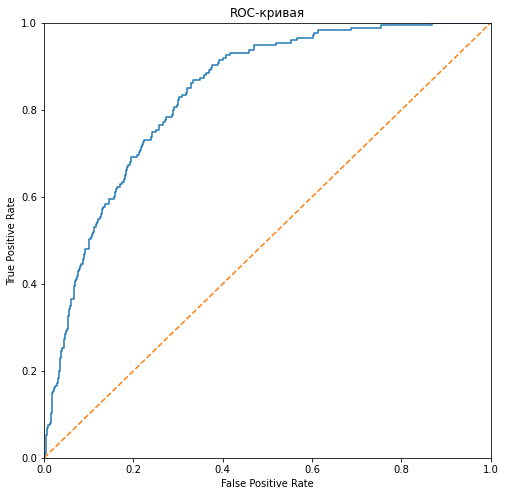

ROC-AUC: 0.8365473255859451


In [76]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [77]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [78]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.9936622901172603,
 {'num_leaves': 47,
  'n_estimators': 940,
  'max_depth': 24,
  'learning_rate': 0.1,
  'boosting_type': 'dart'})

In [79]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [80]:
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('LGBM_pipline+upsample+get_dummies')

In [81]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,14828
1,bmi,9673
2,avg_glucose_level,9194
3,smoking_status_2.0,1007
4,gender_0.0,987
5,smoking_status_3.0,931
6,work_type_3.0,788
7,work_type_2.0,760
8,smoking_status_1.0,741
9,hypertension_0.0,686


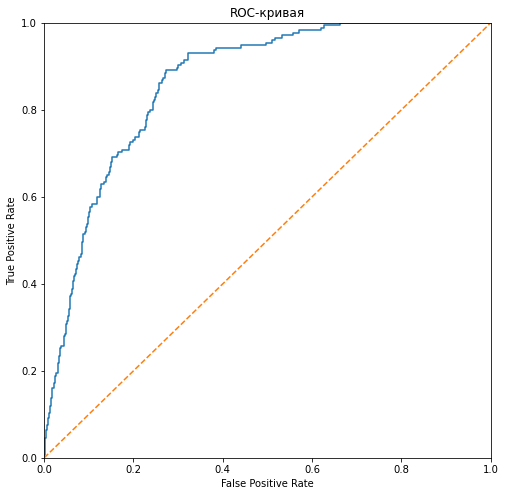

ROC-AUC: 0.8631435614508746


In [82]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Модели Pipline+get_dummies

In [83]:
X_df_pl = pl.fit_transform(X_df)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=state)
col_dummies = ['gender', 'ever_married', 'work_type', 'smoking_status', 'hypertension', 'heart_disease']
X_train = pd.get_dummies(X_train, columns=col_dummies)
X_val = pd.get_dummies(X_val, columns=col_dummies)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11477, 20), (3826, 20), (11477, 1), (3826, 1))

# Catboost

In [84]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6028155	test: 0.6128089	test1: 0.6394364	best: 0.6394364 (0)	total: 661ms	remaining: 5m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4805627087
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6050892	test: 0.6117231	test1: 0.6348175	best: 0.6348175 (0)	total: 700ms	remaining: 5m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4730733083
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6054994	test: 0.6126114	test1: 0.6364284	best: 0.6364284 (0)	total: 658ms	remaining: 5m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4785557757
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6045712	test: 0.6122006	test1: 0.6394150	best: 0.6394150 (0)	total: 639ms	remaining: 5m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4934826698
bestIteration = 9

Shrink model to first 10 iterations.
0:	learn: 0.6006057	test: 0.6121910	test1

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000016500187FA0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [85]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8856029280283165,
 {'learning_rate': 0.01, 'l2_leaf_reg': 2, 'iterations': 250, 'depth': 4})

In [86]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6872325	total: 20.1ms	remaining: 5.01s
1:	learn: 0.6816937	total: 24.3ms	remaining: 3.02s
2:	learn: 0.6759927	total: 29ms	remaining: 2.39s
3:	learn: 0.6710600	total: 33.4ms	remaining: 2.05s
4:	learn: 0.6658795	total: 37.5ms	remaining: 1.84s
5:	learn: 0.6604572	total: 41.8ms	remaining: 1.7s
6:	learn: 0.6554731	total: 45.7ms	remaining: 1.59s
7:	learn: 0.6501091	total: 50ms	remaining: 1.51s
8:	learn: 0.6456685	total: 54ms	remaining: 1.45s
9:	learn: 0.6413061	total: 58.1ms	remaining: 1.39s
10:	learn: 0.6374172	total: 62.4ms	remaining: 1.36s
11:	learn: 0.6334902	total: 66.8ms	remaining: 1.32s
12:	learn: 0.6288123	total: 70.3ms	remaining: 1.28s
13:	learn: 0.6246247	total: 74.4ms	remaining: 1.25s
14:	learn: 0.6203239	total: 78.5ms	remaining: 1.23s
15:	learn: 0.6160730	total: 83ms	remaining: 1.21s
16:	learn: 0.6124658	total: 87.3ms	remaining: 1.2s
17:	learn: 0.6088653	total: 92.1ms	remaining: 1.19s
18:	learn: 0.6058018	total: 96.5ms	remaining: 1.17s
19:	learn: 0.6017660	total: 101m

In [87]:
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('Catboost_pipline+get_dummies')

In [88]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,66.965376
1,avg_glucose_level,9.086515
2,bmi,8.504268
3,ever_married_0.0,2.420278
4,ever_married_1.0,2.409810
5,smoking_status_3.0,2.000894
6,work_type_4.0,1.571426
7,smoking_status_0.0,1.295620
8,smoking_status_2.0,0.988424
9,work_type_2.0,0.919604


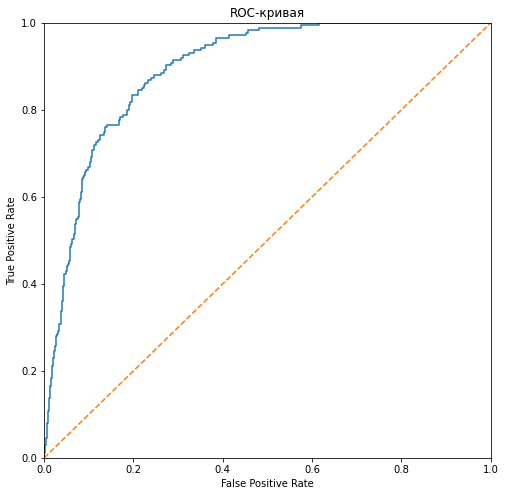

ROC-AUC: 0.8941518957624135


In [89]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [90]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [91]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8818041153202344,
 {'num_leaves': 92,
  'n_estimators': 440,
  'max_depth': 3,
  'learning_rate': 0.005,
  'boosting_type': 'gbdt'})

In [92]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [93]:
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('LGBM_pipline+get_dummies')

In [94]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,1244
1,avg_glucose_level,871
2,bmi,551
3,heart_disease_0.0,105
4,gender_0.0,87
5,ever_married_0.0,61
6,work_type_3.0,60
7,smoking_status_3.0,59
8,work_type_2.0,26
9,smoking_status_2.0,16


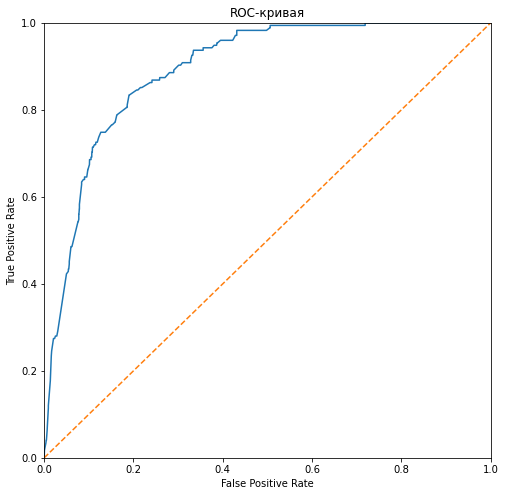

ROC-AUC: 0.8933560277027821


In [95]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Модели without features

# LGBM

In [96]:
drop_list = ['smoking_status_1.0','smoking_status_0.0','gender_1.0','hypertension_0.0','hypertension_1.0'
             ,'work_type_4.0','work_type_1.0','work_type_0.0','ever_married_1.0','heart_disease_1.0',
            'gender_0.0','work_type_2.0','work_type_3.0','smoking_status_2.0',
             'smoking_status_3.0']

In [97]:
X_train = X_train.drop(drop_list, axis=1)
X_val = X_val.drop(drop_list, axis=1)
X_train.shape, X_val.shape

((11477, 5), (3826, 5))

In [98]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

[1000]	valid_0's binary_logloss: 0.0600985	valid_1's binary_logloss: 0.228254
[1000]	valid_0's binary_logloss: 0.0541297	valid_1's binary_logloss: 0.225021
[1000]	valid_0's binary_logloss: 0.0634013	valid_1's binary_logloss: 0.24762
[1000]	valid_0's binary_logloss: 0.0540655	valid_1's binary_logloss: 0.234736
[1000]	valid_0's binary_logloss: 0.0651374	valid_1's binary_logloss: 0.247246


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [99]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8817244394670716,
 {'num_leaves': 144,
  'n_estimators': 260,
  'max_depth': 4,
  'learning_rate': 0.005,
  'boosting_type': 'gbdt'})

In [100]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [101]:
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('LGBM_pipline+get_dummies-feat')

In [102]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,avg_glucose_level,1544
1,age,1132
2,bmi,947
3,heart_disease_0.0,142
4,ever_married_0.0,54


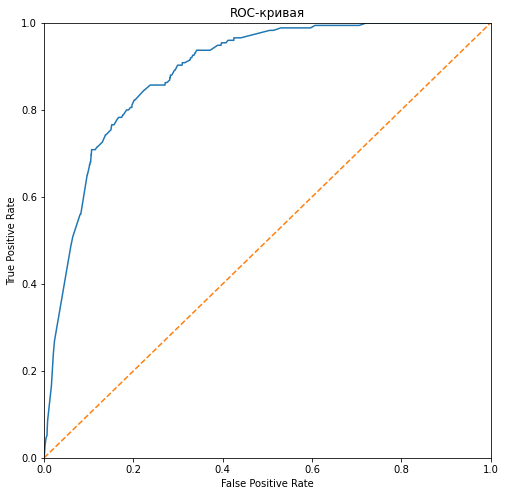

ROC-AUC: 0.8887764604609305


In [103]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Catboost

In [104]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6299520	test: 0.6305730	test1: 0.6309271	best: 0.6309271 (0)	total: 17.2ms	remaining: 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.406579364
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 0.6314305	test: 0.6315505	test1: 0.6338869	best: 0.6338869 (0)	total: 20.4ms	remaining: 7.12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4075863476
bestIteration = 24

Shrink model to first 25 iterations.
0:	learn: 0.6310289	test: 0.6314313	test1: 0.6325052	best: 0.6325052 (0)	total: 4.5ms	remaining: 1.57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4158877429
bestIteration = 18

Shrink model to first 19 iterations.
0:	learn: 0.6293847	test: 0.6297835	test1: 0.6317686	best: 0.6317686 (0)	total: 8.54ms	remaining: 2.98s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4102977319
bestIteration = 21

Shrink model to first 22 iterations.
0:	learn: 0.6276393	test: 0.6292685	test1: 0.

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000016503C12280>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [105]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.882957131943237,
 {'learning_rate': 0.01, 'l2_leaf_reg': 4, 'iterations': 350, 'depth': 4})

In [106]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6871330	total: 3.16ms	remaining: 1.1s
1:	learn: 0.6805611	total: 6.59ms	remaining: 1.15s
2:	learn: 0.6752637	total: 10.1ms	remaining: 1.17s
3:	learn: 0.6707683	total: 12.7ms	remaining: 1.09s
4:	learn: 0.6651364	total: 15.6ms	remaining: 1.08s
5:	learn: 0.6599821	total: 19.1ms	remaining: 1.1s
6:	learn: 0.6545405	total: 22.1ms	remaining: 1.08s
7:	learn: 0.6488138	total: 25.4ms	remaining: 1.08s
8:	learn: 0.6441523	total: 28.3ms	remaining: 1.07s
9:	learn: 0.6386957	total: 31.7ms	remaining: 1.08s
10:	learn: 0.6332542	total: 35.5ms	remaining: 1.09s
11:	learn: 0.6288548	total: 39ms	remaining: 1.1s
12:	learn: 0.6235680	total: 42.3ms	remaining: 1.1s
13:	learn: 0.6183658	total: 45.7ms	remaining: 1.09s
14:	learn: 0.6146596	total: 49ms	remaining: 1.09s
15:	learn: 0.6108231	total: 52.3ms	remaining: 1.09s
16:	learn: 0.6060512	total: 55.3ms	remaining: 1.08s
17:	learn: 0.6022983	total: 58.6ms	remaining: 1.08s
18:	learn: 0.5985616	total: 61.7ms	remaining: 1.07s
19:	learn: 0.5946893	total: 65

In [107]:
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['model'].append('Catboost_pipline+get_dummies-feat')

In [108]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,62.499549
1,avg_glucose_level,14.744819
2,ever_married_0.0,10.996771
3,bmi,10.273397
4,heart_disease_0.0,1.485464


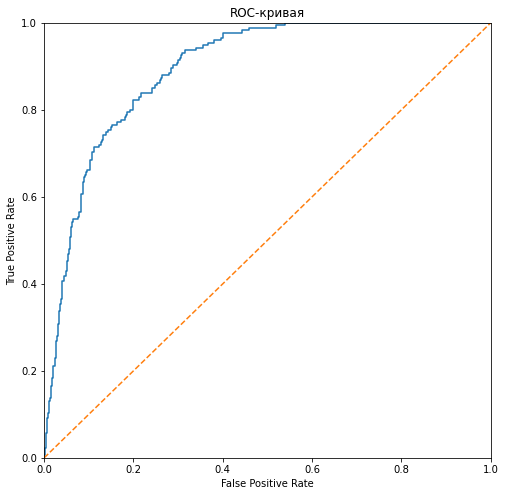

ROC-AUC: 0.8937527878859022


In [109]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Сравненительная таблица моделей

In [110]:
pd.DataFrame(data=models_results).sort_values(by='rocauc', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')

,best_score,rocauc,precision,recall,model
2,0.886993,0.895856,0.845714,0.153051,Catboost_with_pipline
3,0.885365,0.895499,0.834286,0.167816,LGBM_with_pipline
8,0.885603,0.894152,0.868571,0.149166,Catboost_pipline+get_dummies
11,0.882957,0.893753,0.840000,0.147147,Catboost_pipline+get_dummies-feat
9,0.881804,0.893356,0.874286,0.139344,LGBM_pipline+get_dummies
1,0.881561,0.893184,0.874286,0.139471,LGBM_without_pipline
10,0.881724,0.888776,0.857143,0.144231,LGBM_pipline+get_dummies-feat
0,0.884348,0.872847,0.697143,0.202995,Catboost_without_pipline
5,0.993461,0.863586,0.165714,0.273585,LGBM_pipline+upsample
7,0.993662,0.863144,0.177143,0.258333,LGBM_pipline+upsample+get_dummies
